# Experiment Information

Users in the treatment group were exposed to a "Planning Prompt" UI on the Course Outline page - that encouraged users to make a plan for learning and completing the course. Users in the treatment group remained in the group until the end of the experiment. Users were allowed to 
1. enter and save their plan or 
2. dismiss the prompt, which collapsed it for future access.  

See https://openedx.atlassian.net/wiki/display/RET/3.+Planning+Prompts for more information.

# Decisions
1. Segment the user population according to just 2 variations: treatment and control. Don't create 3 segments (treatment_saved, treatment_not_saved and control) since the treatment_saved group is a self-selected group.
2. Compute date-difference relative to user-specific exposure to the experiment, not relative to the beginning of the experiment.
3. Remove users who were grouped into multiple variations (they happened to get into both control and treatment groups - either across devices or sessions).
4. Count by users, not by enrollments.

# Setup

In [1]:
%load_ext edx_jupyter

In [2]:
%%vertica
SELECT 'Connected to Vertica!'

password: ········


,?column?
0,Connected to Vertica!


In [3]:
%%vertica
SET TIME ZONE 'UTC'

,?column?


In [4]:
start_time = '2017-06-21'
end_time = '2017-07-08'
experiment_id = '8436781476'

In [5]:
import matplotlib.pyplot as plt
from plotnine import *
from edx_stats import grouped_confidence_intervals
from edx_plot import geom_confidence, theme_confidence

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
%matplotlib inline

## All BI events related to this experiment

In [7]:
%%vertica (start_time=start_time, end_time=end_time)
SELECT
    event_type,
    COUNT(1) AS 'count'
FROM 
    experimental_events_run14.event_records
WHERE
    received_at::TIMESTAMPTZ BETWEEN :start_time AND :end_time
    AND event_type LIKE 'edx.bi.experiment.planning_prompt.%'
    AND event_type != 'edx.bi.experiment.planning_prompt.displayed' -- temp event type from initial testing
GROUP BY
    event_type
ORDER BY
    COUNT(1) DESC

,event_type,count
0,edx.bi.experiment.planning_prompt.display_expa...,251630
1,edx.bi.experiment.planning_prompt.display_coll...,66715
2,edx.bi.experiment.planning_prompt.dismissed,20774
3,edx.bi.experiment.planning_prompt.save_succeeded,6309
4,edx.bi.experiment.planning_prompt.expanded,1314
5,edx.bi.experiment.planning_prompt.save_failed,89
6,edx.bi.experiment.planning_prompt.validation_f...,6


* **display_expanded**: planning prompt was displayed in the expanded state to the user
* **display_collapsed**: planning prompt was displayed in the collapsed state to the user
* **dismissed**: planning prompt was dismissed by the user, which puts it in the collapsed state for future access.
* **save_succeeded**: a plan was created and saved by the user.
* **expanded**: a previously collapsed planning prompt was expanded by the user.
* **save_failed**: probably a server-side error?
* **validation_failed**: user tried to save an empty (null) plan.

## Learners in the experiment

### Learners by variation groups -> TABLE user_variations

Group users by their variations (control versus treatment), and then later remove users who ended up in multiple variations.

In [8]:
%%vertica (start_time=start_time, end_time=end_time, experiment_id=experiment_id)
DROP TABLE IF EXISTS user_variations_raw;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS user_variations_raw
ON COMMIT PRESERVE ROWS AS
SELECT
    user_id,
    anonymous_id,
    received_at::TIMESTAMPTZ,
    timestamp::TIMESTAMPTZ,
    experimentid AS experiment_id,
    experimentname AS experiment_name,
    variationid::INT AS variation_id,
    variationname AS variation_name,
    CASE
        WHEN variationid = '8435930136' THEN 'treatment'
        ELSE 'control'
    END AS 'variation_group'
FROM
    experimental_events_run14.event_records
WHERE
    received_at::TIMESTAMPTZ BETWEEN :start_time AND :end_time
    AND event_type = 'Experiment Viewed'
    AND experimentid = :experiment_id
    AND user_id is not NULL
    AND REGEXP_LIKE(user_id, '^[0-9]+');

SELECT
    variation_group,
    COUNT(DISTINCT user_id)
FROM user_variations_raw
GROUP BY variation_group;

,variation_group,COUNT
0,control,50862
1,treatment,51216


Check how many users saw multiple variations.

In [9]:
%%vertica -> variations_per_user
SELECT
    user_id,
    MIN(variation_group) AS variation_group,
    COUNT(DISTINCT variation_group) AS variations_per_user
FROM
    user_variations_raw
GROUP BY 1

In [10]:
num_users = variations_per_user.groupby('variations_per_user').count()
total_users = num_users.user_id.sum()
num_users['percent_of_population'] = (num_users.user_id / float(total_users)) * 100
num_users[['user_id', 'percent_of_population']]

,user_id,percent_of_population
variations_per_user,,
1,89072,93.195919
2,6503,6.804081


Exclude users with multiple variations.

In [11]:
%%vertica
DROP TABLE IF EXISTS user_variations;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS user_variations
ON COMMIT PRESERVE ROWS AS
SELECT
    user_id,
    MIN(received_at) AS received_at,
    MIN(timestamp) AS timestamp,
    MIN(variation_group) AS variation_group,
    MIN(anonymous_id) AS anonymous_id,
    MIN(experiment_id) AS experiment_id,
    MIN(experiment_name) AS experiment_name,
    MIN(variation_id) AS variation_id,
    MIN(variation_name) AS variation_name
FROM
    user_variations_raw
GROUP BY 1
HAVING COUNT(DISTINCT variation_group) = 1;

SELECT
    variation_group,
    COUNT(DISTINCT user_id)
FROM user_variations
GROUP BY variation_group;

,variation_group,COUNT
0,treatment,44713
1,control,44359


### Persist user variations information in ret.experiment_views table

In [38]:
%%vertica (start_time=start_time, end_time=end_time, experiment_id=experiment_id)
DELETE FROM ret.experiment_views WHERE experiment_id = :experiment_id;
INSERT INTO ret.experiment_views 
(
    received_at,
    timestamp,
    anonymous_id,
    raw_user_id,
    user_id,
    experiment_id,
    experiment_name,
    variation_id,
    variation_name,
    course_id,
    path,
    url
)
SELECT
    received_at,
    timestamp,
    anonymous_id,
    user_id AS raw_user_id,
    user_id::INT,
    experiment_id::INT,
    experiment_name,
    variation_id,
    variation_name,
    NULL AS course_id,
    NULL AS path,
    NULL AS url
FROM
    user_variations;
    
SELECT COUNT(user_id) from ret.experiment_views where experiment_id = :experiment_id;

,OUTPUT
0,89072


### Archive: Learners according to 3 groups: treatment_saved, treatment_not_saved, control *(discarded)*

In [41]:
%%vertica (start_time=start_time, end_time=end_time)
DROP TABLE IF EXISTS users_in_treatment_group;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS users_in_treatment_group
ON COMMIT PRESERVE ROWS AS
SELECT
    user_id,
    SUM(prompt_saved) as prompt_saved,
    SUM(prompt_viewed) as prompt_viewed,
    MIN(received_at)
FROM
(
    SELECT
        er.user_id,
        er.received_at,
        CASE
            WHEN event_type = 'edx.bi.experiment.planning_prompt.save_succeeded' THEN 1 ELSE 0
        END AS prompt_saved,
        CASE
            WHEN event_type = 'edx.bi.experiment.planning_prompt.display_expanded' THEN 1 ELSE 0
        END AS prompt_viewed
    FROM
        experimental_events_run14.event_records er
        JOIN user_variations v ON (er.user_id = v.user_id)
    WHERE
        er.received_at BETWEEN :start_time AND :end_time
        AND event_type IN (
            'edx.bi.experiment.planning_prompt.save_succeeded', 
            'edx.bi.experiment.planning_prompt.display_expanded'
        )
) AS return
GROUP BY user_id;

DROP TABLE IF EXISTS user_groups_3_groups;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS user_groups_3_groups
ON COMMIT PRESERVE ROWS AS
SELECT
    uv.user_id,
    uv.received_at,
    CASE
        WHEN utg.prompt_saved > 0 THEN 'treatment_saved'
        WHEN utg.prompt_viewed > 0 THEN 'treatment_not_saved'
        ELSE 'control'
    END AS user_group
FROM
    user_variations uv
LEFT JOIN
    users_in_treatment_group utg
    ON utg.user_id = uv.user_id;
    
SELECT
    user_group,
    count(user_id)
FROM
    user_groups_3_groups
GROUP BY
    user_group;

,user_group,count
0,treatment_saved,3291
1,treatment_not_saved,41080
2,control,44701


### Archive: Learners who visited Course Outline page *(sanity check)*

This is just a sanity check against the numbers we got in the user_variations table. 

In [42]:
%%vertica (start_time=start_time, end_time=end_time)
DROP TABLE IF EXISTS course_outline_visits;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS course_outline_visits ON COMMIT PRESERVE ROWS AS
SELECT
    er.user_id,
    LEFT(RIGHT(er.url, LENGTH(er.url) - 32), LENGTH(RIGHT(er.url, LENGTH(er.url) - 32)) - 8) AS computed_course_id,
    date,
    event_source,
    event_type
FROM
    experimental_events_run14.event_records er
    JOIN user_variations v ON (er.user_id = v.user_id)
WHERE
    event_source = 'client' AND
    event_type = 'page' AND
    er.url LIKE 'https://courses.edx.org/courses/%/course/' AND
    er.received_at::TIMESTAMPTZ BETWEEN :start_time AND :end_time;

SELECT
    COUNT (DISTINCT user_id)
FROM
    course_outline_visits;

,COUNT
0,88953


## Engagement Analysis

Plot engagement across days since exposure, grouped by variation.

In [43]:
%%vertica (end_time=end_time) -> engaged_users
SELECT
    days_since_user_exposed,
    variation_group,
    COUNT(DISTINCT user_id) as count_engaged_users
FROM
(
    SELECT
        uv.user_id,
        uv.variation_group,
        DATEDIFF('day', received_at, bi_engage.date) as days_since_user_exposed
    FROM
        user_variations uv
    JOIN
        business_intelligence.activity_engagement_user_daily bi_engage
        ON bi_engage.user_id = uv.user_id
        AND bi_engage.date BETWEEN uv.received_at AND :end_time
        AND bi_engage.is_engaged
) as return
GROUP BY
    1, 2
ORDER BY 1

In [44]:
engaged_users_ix = engaged_users.dropna().set_index(['variation_group', 'days_since_user_exposed'])

In [45]:
%%vertica -> group_sizes
SELECT
    variation_group,
    COUNT (user_id)
FROM
    user_variations
GROUP BY 1;

In [46]:
group_sizes

,variation_group,COUNT
0,control,44359
1,treatment,44713


In [47]:
group_sizes.set_index('variation_group', inplace=True)

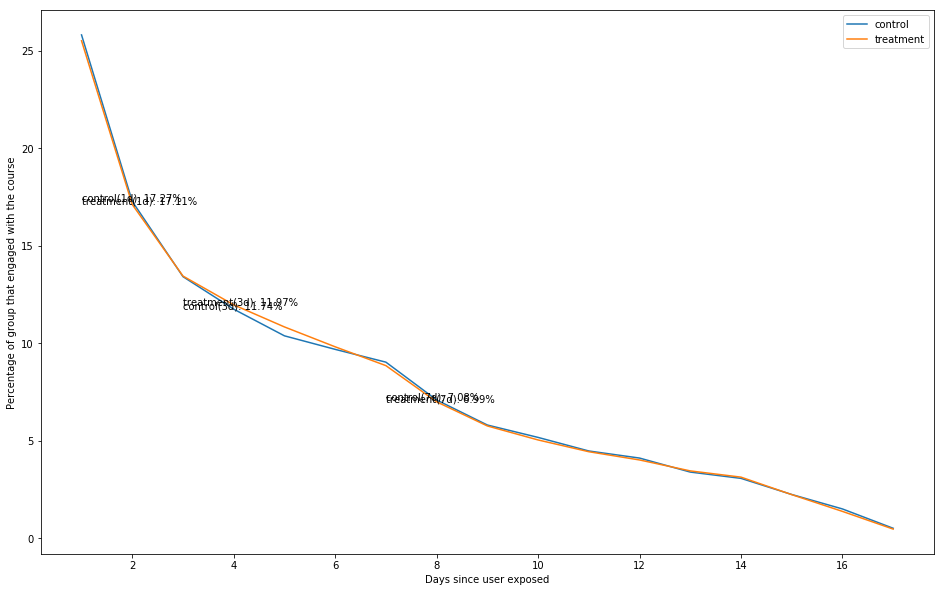

In [48]:
fig = plt.figure(figsize=(16, 10))
for group_name in group_sizes.index:
    data = engaged_users_ix.loc[group_name]
    x = list(data.index)
    y = list((data.count_engaged_users/group_sizes.loc[group_name].COUNT)*100)
    plt.plot(x, y, label=group_name)
    for ann_x in (1, 3, 7, 21, 28):
        if x[-1] < ann_x:
            break
        plt.annotate(
            '{0}({1}d): {2}%'.format(group_name, ann_x, round(y[ann_x], 2)),
            xy=(ann_x, y[ann_x]),
            xytext=(ann_x, y[ann_x])
        )
    plt.legend()
ax = fig.get_axes()[0]
ax.set_xlabel('Days since user exposed')
ax.set_ylabel('Percentage of group that engaged with the course')
None

## Statistically Significance Analysis based on User-relative Exposed Dates

### is_engaged by week (user-relative exposed dates)

Number of days engaged, per week, since date exposed.

In [49]:
%%vertica (end_time=end_time) -> is_engaged_by_week_user_relative_date
SELECT
    uv.user_id,
    uv.variation_group,
    FLOOR(DATEDIFF('day', uv.received_at, bi_engage.date) / 7) AS weeks_since_user_exposed,
    MAX(bi_engage.is_engaged) AS is_engaged
FROM
    user_variations uv
JOIN
    business_intelligence.activity_engagement_user_daily bi_engage
    ON bi_engage.user_id = uv.user_id
    AND bi_engage.date BETWEEN uv.received_at AND :end_time
GROUP BY
    1, 2, 3
ORDER BY 1

In [50]:
is_engaged_by_week_user_relative_date_conf_intervals = grouped_confidence_intervals(
    is_engaged_by_week_user_relative_date.reset_index(),
    variant_col='variation_group',
    value_col='is_engaged',
    ctrl_name='control',
    group_cols=['weeks_since_user_exposed']
)

/app/lib/edx_stats.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


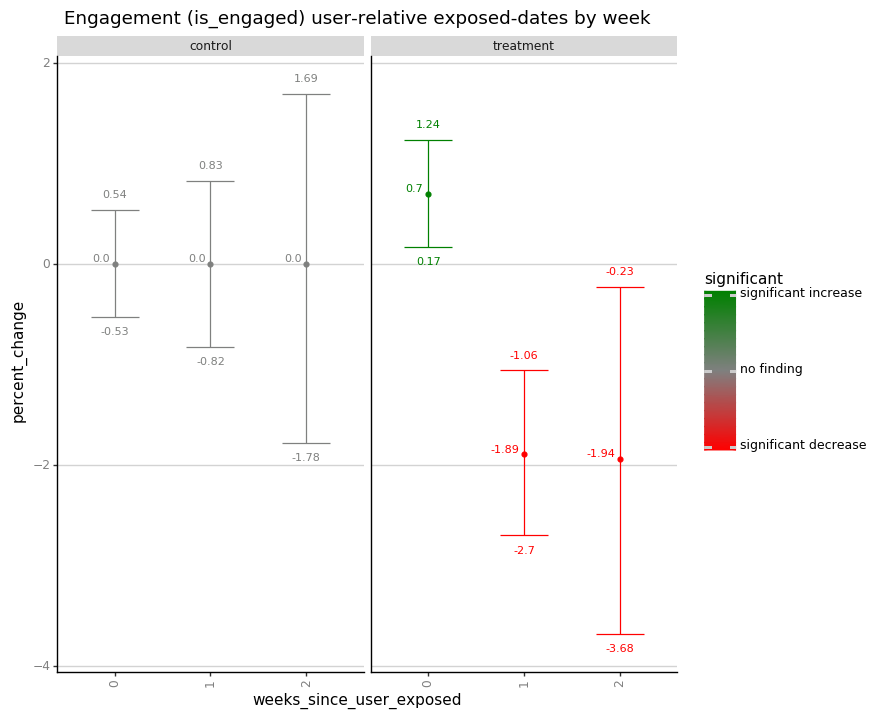

<ggplot: (8749986636187)>

In [51]:
(
    ggplot(is_engaged_by_week_user_relative_date_conf_intervals.reset_index(), aes(
        x='weeks_since_user_exposed',
        y='percent_change',
        ymin='lower_bound',
        ymax='upper_bound',
        color='significant',
        label_size=0.5,
    ))
    + geom_confidence()
    + facet_grid(". ~ variation_group")
    + theme_confidence()
    + ggtitle("Engagement (is_engaged) user-relative exposed-dates by week")
)

### cnt_engaged_activity by week (user-relative exposed dates)

Number of engagement activities, per week, since date exposed.

In [52]:
%%vertica (end_time=end_time) -> cnt_engaged_by_week_user_relative_date
SELECT
    uv.user_id,
    uv.variation_group,
    FLOOR(DATEDIFF('day', uv.received_at, bi_engage.date) / 7) AS weeks_since_user_exposed,
    SUM(bi_engage.cnt_engaged_activity) AS cnt_engaged_activity
FROM
    user_variations uv
JOIN
    business_intelligence.activity_engagement_user_daily bi_engage
    ON bi_engage.user_id = uv.user_id
    AND bi_engage.date BETWEEN uv.received_at AND :end_time
GROUP BY
    1, 2, 3
ORDER BY 1

In [53]:
cnt_engaged_by_week_user_relative_date_conf_intervals = grouped_confidence_intervals(
    cnt_engaged_by_week_user_relative_date.reset_index(),
    variant_col='variation_group',
    value_col='cnt_engaged_activity',
    ctrl_name='control',
    group_cols=['weeks_since_user_exposed']
)

/app/lib/edx_stats.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


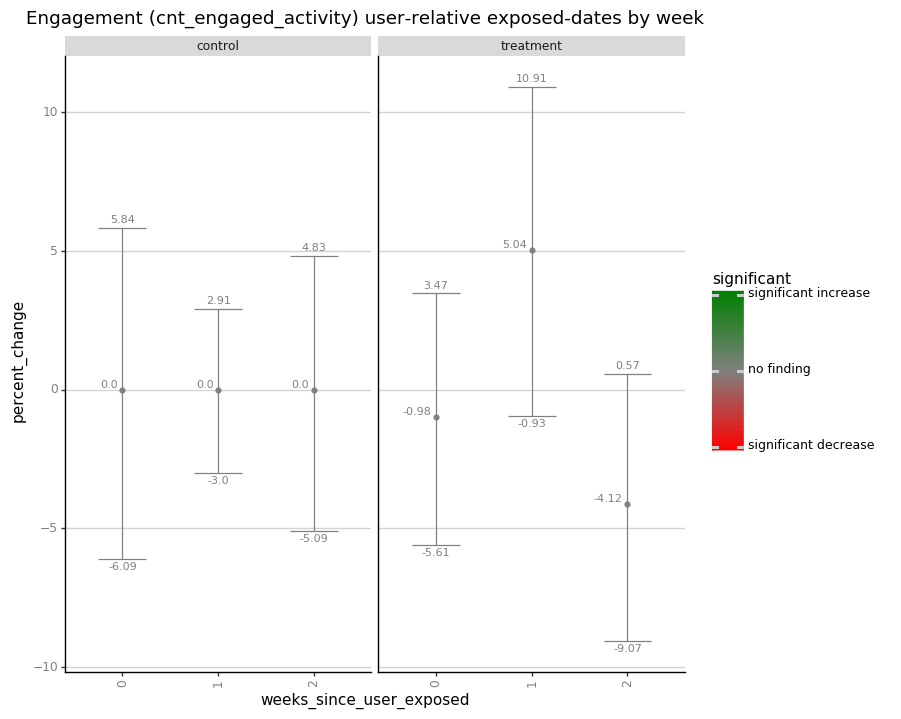

<ggplot: (-9223363286869514450)>

In [54]:
(
    ggplot(cnt_engaged_by_week_user_relative_date_conf_intervals.reset_index(), aes(
        x='weeks_since_user_exposed',
        y='percent_change',
        ymin='lower_bound',
        ymax='upper_bound',
        color='significant',
        label_size=0.5,
    ))
    + geom_confidence()
    + facet_grid(". ~ variation_group")
    + theme_confidence()
    + ggtitle("Engagement (cnt_engaged_activity) user-relative exposed-dates by week")
)

## Treatment on the Treated Analysis
See https://openedx.atlassian.net/wiki/display/RET/Data+Analysis

**Note:** We still don't see any statistically significant impact in long-term engagement within the course.

In [55]:
threshold_for_number_of_engagement_activities = 50

In [56]:
%%vertica (end_time=end_time, threshold_for_number_of_engagement_activities=threshold_for_number_of_engagement_activities)
DROP TABLE IF EXISTS user_variations_for_active_users;
CREATE LOCAL TEMPORARY TABLE IF NOT EXISTS user_variations_for_active_users
ON COMMIT PRESERVE ROWS AS
SELECT
    uv.user_id,
    uv.received_at,
    uv.variation_group
FROM
    user_variations uv
JOIN
    business_intelligence.activity_engagement_user_daily bi_engage
    ON bi_engage.user_id = uv.user_id
GROUP BY 1, 2, 3
HAVING
    SUM(bi_engage.cnt_engaged_activity) > :threshold_for_number_of_engagement_activities;
    
SELECT count(user_id) from user_variations_for_active_users;

,count
0,48750


In [57]:
%%vertica (end_time=end_time) -> cnt_engaged_by_week_for_active_users
SELECT
    uv.user_id,
    uv.variation_group,
    FLOOR(DATEDIFF('day', uv.received_at, bi_engage.date) / 7) AS weeks_since_user_exposed,
    SUM(bi_engage.cnt_engaged_activity) AS cnt_engaged_activity
FROM
    user_variations_for_active_users uv
JOIN
    business_intelligence.activity_engagement_user_daily bi_engage
    ON bi_engage.user_id = uv.user_id
    AND bi_engage.date BETWEEN uv.received_at AND :end_time
GROUP BY
    1, 2, 3
ORDER BY 1

In [58]:
cnt_engaged_by_week_for_active_users_conf_intervals = grouped_confidence_intervals(
    cnt_engaged_by_week_for_active_users.reset_index(),
    variant_col='variation_group',
    value_col='cnt_engaged_activity',
    ctrl_name='control',
    group_cols=['weeks_since_user_exposed']
)

/app/lib/edx_stats.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


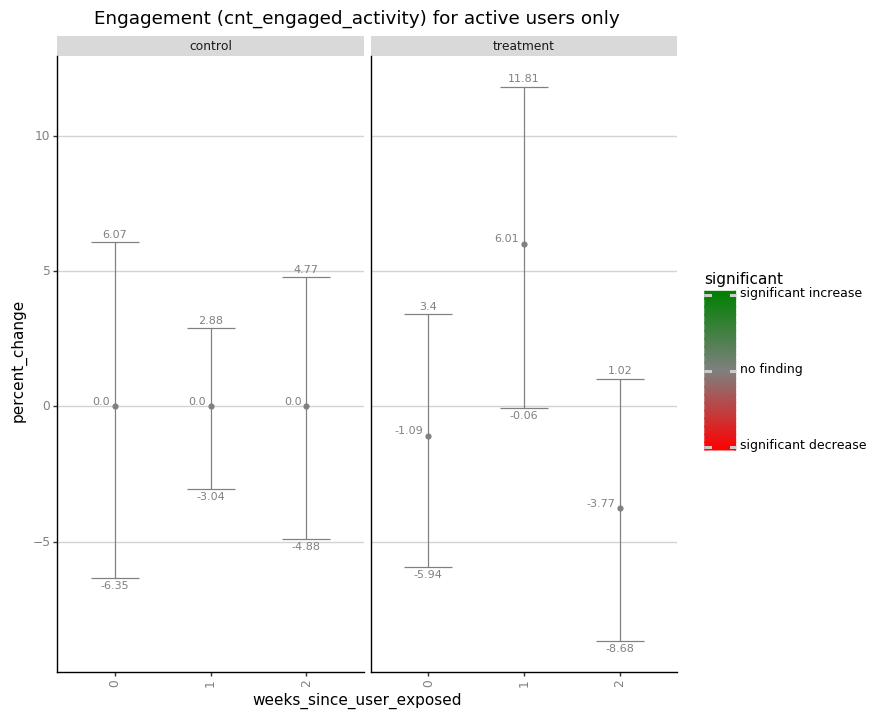

<ggplot: (-9223363286822518426)>

In [59]:
(
    ggplot(cnt_engaged_by_week_for_active_users_conf_intervals.reset_index(), aes(
        x='weeks_since_user_exposed',
        y='percent_change',
        ymin='lower_bound',
        ymax='upper_bound',
        color='significant',
        label_size=0.5,
    ))
    + geom_confidence()
    + facet_grid(". ~ variation_group")
    + theme_confidence()
    + ggtitle("Engagement (cnt_engaged_activity) for active users only")
)